In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
import train

from sklearn import decomposition
import matplotlib.gridspec as grd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = data_tracks.get_data()
n = df.shape[0]

# logistic classifier

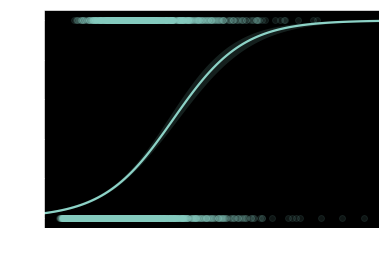

In [2]:
sns.regplot('X_max', 'y_thresh', df, scatter_kws={'alpha': 0.1}, logistic=True)
plt.hist(df['lifetime'][df['y_thresh']==0], alpha=0.5)
plt.hist(df['lifetime'][df['y_thresh']==1], alpha=0.5)
plt.show()

In [10]:
df.keys()

Index(['X', 'Y', 'X_pval', 'Y_pvals', 'catIdx', 'total_displacement',
       'mean_square_displacement', 'lifetime', 'x_pos', 'y_pos', 'cell_num',
       'len', 'X_max', 'X_min', 'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std',
       'rise', 'fall', 'max_diff', 'min_diff', 'outcome_score', 'outcome',
       'sc_0', 'sc_1', 'sc_2', 'sc_3', 'sc_4', 'sc_5', 'sc_6', 'sc_7', 'sc_8',
       'sc_9', 'sc_10', 'sc_11'],
      dtype='object')

In [ ]:
outcome_def = 'y_consec_sig'
for balancing in ['ros']:
    for model_type in tqdm(['gb', 'logistic', 'dt', 'svm', 'rf', 'mlp2']):
        for num_feats in [4, 9, 11]: #[23]:# [4, 6, 7, 9, 11]:
    #         feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 'rise', 'fall']
            scs = [f'sc_{i}' for i in range(12)]
            feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
                          'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff'] + scs
            feat_names = feat_names[:num_feats]
            train.train(df, feat_names=feat_names, model_type=model_type, balancing=balancing, outcome_def=outcome_def,
                        out_name=f'results/classify_outcome={outcome_def}/{model_type}_{balancing}_{len(feat_names)}.pkl')

In [ ]:
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
                          'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff']
X = df[feat_names]
X = (X - X.mean()) / X.std()
y = df['y_thresh'].values

# visualize correlations between the data
mat = deepcopy(X)
mat['y_thresh'] = y

# make fig
plt.figure(dpi=200)
sns.heatmap(mat.corr(method='spearman'), cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), vmin=-1, vmax=1)
plt.show()

# dim reduction

In [68]:
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
                          'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff']
X = df[feat_names]
X = (X - X.mean()) / X.std()
y = df['y_thresh'].values

**look at pcs**

In [ ]:
def plot_pcs(pca, comps):

    # create a 2 X 2 grid 
    gs = grd.GridSpec(2, 2, height_ratios=[2,10], 
                      width_ratios=[12, 1], wspace=0.1, hspace=0)

    var_norm = pca.explained_variance_ / np.sum(pca.explained_variance_) * 100
    # plot explained variance
    ax2 = plt.subplot(gs[0])
    ax2.bar(np.arange(0, comps.shape[1]), var_norm, 
            color='gray', width=0.8)
    plt.title('Explained variance (%)')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_yticks([0, max(var_norm)])
    plt.xlim((-0.5, comps.shape[1]-0.5))
    
    # plot pcs
    ax = plt.subplot(gs[2])
    p = ax.imshow(comps, interpolation='None', cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), aspect='auto') #, vmin=-1, vmax=1)
#     plt.ylabel('Feature number')
    plt.xlabel('PCA component number')
    ax.set_yticklabels(list(X))
    ax.set_yticks(range(len(list(X))))
    

    # make colorbar
    colorAx = plt.subplot(gs[3])
    cb = plt.colorbar(p, cax = colorAx)
    plt.show()
    

# perform pca
pca = decomposition.PCA(whiten=True)
# pca = decomposition.SparsePCA()
# pca = decomposition.NMF()
pca.fit(X)
comps = pca.components_.transpose()
plt.figure(figsize=(6, 5), dpi=200)
plot_pcs(pca, comps)

In [ ]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)
plt.figure(dpi=200)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['y_thresh'].values, alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
#             cdf[np.arange(X.shape[0]), cmap='viridis', alpha=0.1)
plt.show()